# Learning and controlling a room's temperature
### Farzad Vatandoust/email: vatandoustf@gamil.com

## Load The Data

In [1]:
using CSV, DataFrames
df = CSV.read("data-B90102-30m.csv", DataFrame)
room_temp = df[:, :room_temp];
htg_setpoint = df[:, :htg_setpoint];
supply_temp = df[:, :supply_temp];
airflow_current = df[:, :airflow_current];

### Train/Test/Validation
Useful link https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

In [2]:
train_nu = floor(Int, 0.8 * length(room_temp))
test_nu = floor(Int, 0.1 * length(room_temp))

train_room_temp = room_temp[1:train_nu]
test_room_temp = room_temp[train_nu+1:train_nu+test_nu]
val_room_temp = room_temp[train_nu+test_nu:end]

train_supply_temp = supply_temp[1:train_nu]
test_supply_temp = supply_temp[train_nu+1:train_nu+test_nu]
val_supply_temp = supply_temp[train_nu+test_nu:end]

train_airflow_current = airflow_current[1:train_nu]
test_airflow_current = airflow_current[train_nu+1:train_nu+test_nu]
val_airflow_current = airflow_current[train_nu+test_nu:end];


# Learn a differential equation model

useful link: https://docs.sciml.ai/DiffEqParamEstim/stable/

In [3]:
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, Zygote, OptimizationOptimJL, OptimizationBBO
using DifferentialEquations, Plots, DiffEqParamEstim, Optimization,  OptimizationNLopt, NLopt


In [4]:
using OptimizationMOI

## Model Defenition
- p[1, 2, 3, 4] = K, Ta, ca, dt, C
- u[1] = T
- we have some function Ts and MS
- Useful link https://discourse.julialang.org/t/solving-ode-parameters-using-experimental-data-with-control-inputs/66614/19

In [5]:

function f(du, u,p,t)
    du[1] = (p[1]*(p[2]-u[1]) .+
    train_airflow_current[[floor(Int, x) for x in t.+1]].*p[3]*
    (train_supply_temp[[floor(Int, x) for x in t.+1]].-u[1]) .+ p[4]) ./ p[5]

end


f (generic function with 1 method)

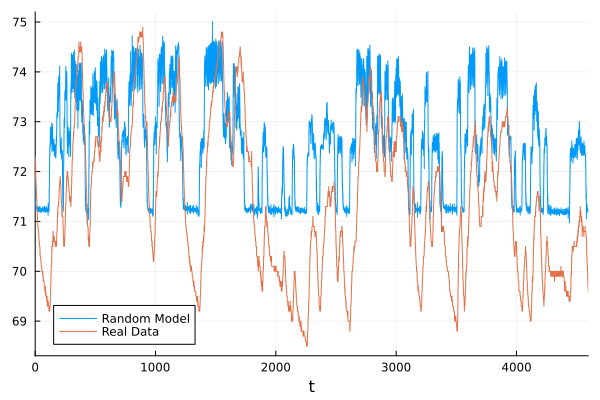

In [6]:
first_n = length(train_room_temp)
u0 = [train_room_temp[1]]
tspan = (0,first_n-1)
# p = K, Ta, ca, dt, C
p = [68, 72, 0.01, 6, 10]
prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob,Tsit5())
plot(sol, label = "Random Model")
plot!(train_room_temp[1:first_n], label = "Real Data")

In [7]:

t = collect(0:first_n-1);
data = convert(Array, train_room_temp[1:first_n]);

### Cost function


In [ ]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                    Optimization.AutoForwardDiff(),
                                     maxiters=10000,verbose=false)

### Robust cost function

In [8]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data, differ_weight=0.3,data_weight=0.7),
                                    Optimization.AutoForwardDiff(),
                                     maxiters=10000,verbose=false)

(::OptimizationFunction{true, Optimization.AutoForwardDiff{nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(f), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Int64}, Matrix{Float64}, Float64, Float64, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, t

## Simple optimizer 
Useful link: https://docs.sciml.ai/Optimization/stable/API/solve/

In [9]:
optprob = Optimization.OptimizationProblem(cost_function, 
                                            [10.0, 10, 10, 10, 2000])

println("objective")
function mycallback(x, objective)
    println(objective)
    false
end
optsol = solve(optprob, BFGS(), maxiters=50, reltol=1e-7, callback = mycallback)

objective


533742.5165902356


388667.3985587805
387819.2576576111

304814.94979331695


275715.8662851184


194111.4043486016


168551.05456889296


136508.19846389914


108915.75193620716


80201.96015960768
25421.841386538897


2570.9079857141983


1255.1193255362928


1038.7897615647096


949.1629148640704


910.7759875318977


910.7759875989566


910.7759876248638


u: 5-element Vector{Float64}:
   44.79283870179218
   64.67287833271422
    0.011956607062629286
  258.7864718461701
 2093.941098400554

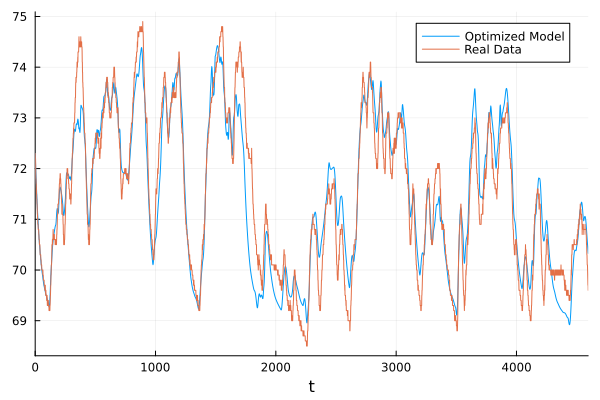

In [10]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob,Tsit5())
plot(newsol, label = "Optimized Model")
plot!(room_temp[1:first_n], label = "Real Data")

## Global optimizer



Improved Stochastic Ranking Evolution Strategy

In [15]:
initial = [10.0, 10.0, 10.0, 10.0, 1000]
lower = [0.0, 0.0, 0.0, 0.0, 1000.0]
upper = [200.0, 200.0, 200.0, 10000.0, 10000.0]
optprob = Optimization.OptimizationProblem(cost_function,
initial, lb = lower, ub = upper)

println("objective")
function mycallback(x, objective)
    println(objective)
    false
end
res = solve(optprob, OptimizationMOI.MOI.OptimizerWithAttributes(
    NLopt.Optimizer, "algorithm" => :GN_ISRES,
     "xtol_rel" => 1e-8, "maxeval" => 200000), call=mycallback)

objective

u: 5-element Vector{Float64}:
  188.9980706174376
   63.23058881678946
    0.051322625103432204
 1377.8106194333805
 9755.254635220175

In [16]:
cost_function(res.u)

805.5714083420365

190.2385397401455
   23.364844716718103
    0.05367168967558882
 8945.906444867143
 9459.504201872069

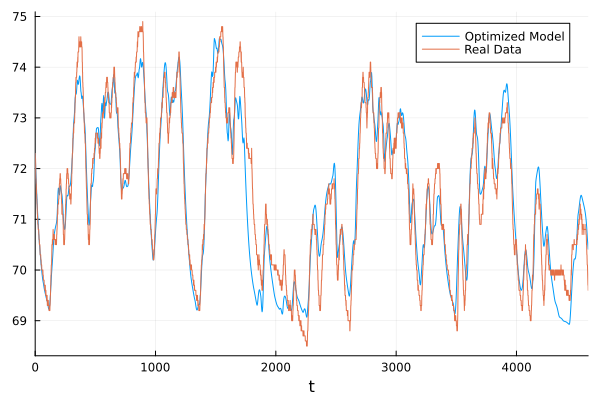

In [14]:
newprob = remake(prob, p = res.u)
newsol = solve(newprob,Tsit5())
plot(newsol, label = "Optimized Model")
plot!(room_temp[1:first_n], label = "Real Data")


In [ ]:
optprob = Optimization.OptimizationProblem(cost_function,[10.0, 10.0, 10.0, 10.0, 1000])
opt = Opt(:GN_ESCH, 5)
lower_bounds!(opt,[0.0, 0.0, 0.0, 0.0, 1000.0])
upper_bounds!(opt,[200.0, 200.0, 200.0, 10000.0, 10000.0])
xtol_rel!(opt,1e-5)
it = 10000
maxeval!(opt, it)
res = solve(optprob, opt)
res.objective

In [ ]:
res.u

5-element Vector{Float64}:
   88.80725334513038
   38.16583102472163
    0.02139977201680439
 2877.286906206373
 4255.502810499004

In [ ]:
newprob = remake(prob, p = res.u)
newsol = solve(newprob,Tsit5())
plot(newsol, label = "Optimized Model")
plot!(room_temp[1:first_n], label = "Real Data")